In [1]:
from src.data.eeg_measurement import EegMeasurement
from src.data.eeg_attention_pytorch_dataset import EegAttentionDataset
from src.evaluation.eval_vanilla_ridge import RidgeEvaluator
import numpy as np
import git
import os
import pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.collections import LineCollection
import scipy
import pickle
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
import json
import scipy.stats as stats
import pingouin as pg

In [2]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]

fig_path = os.path.join(base_dir, 'reports', 'figures', 'complete_dataset')

db_list = [0, 5, 10, 15, 20, 25][::-1]
cnn_model_id_list = [153, 306, 305, 303, 301, 300]
ridge_model_id_list = [20, 56, 55, 53, 51, 50]

In [3]:
cnn_model_id_list

[153, 306, 305, 303, 301, 300]

In [4]:
def load_from_pickle(path, rt_as_np = True):
    with open(path, 'rb') as f:
        data = pickle.load(f)
        if rt_as_np:
            data = np.array(data)
    return data

In [5]:
def get_60s_mean_cnn(data):
    return np.mean(data, axis=(1))[:,0]

In [6]:
def get_60s_mean_ridge(data):
    return np.mean(data, axis=(0))

In [7]:
def sig_decoding(r_attended, r_distractor, long_res=False):
    n_corr = np.sum(r_attended[:,:,0] > r_distractor[:,:,0])
    n_total =r_attended[:,:,0].size
    res = scipy.stats.binomtest(n_corr, n_total, p=0.5, alternative='two-sided')
    if long_res:
        return res
    else:
        return res.pvalue

In [8]:
def get_attended_distractor_path(model_id, CNN = True):
    if CNN:
        attended_path = os.path.join(base_dir, f'reports/metrics/cnn/{str(model_id)}pickled_raw/attended_scores_mean.pkl')
        distractor_path = os.path.join(base_dir, f'reports/metrics/cnn/{str(model_id)}pickled_raw/distractor_scores_mean.pkl')
    else:
        if model_id < 40:
            attended_path = os.path.join(base_dir, f'reports/metrics/ridge/0{str(model_id)}/windowed_accuracies/windowed_attended_scores_averaged0{str(model_id)}.npy')
            distractor_path = os.path.join(base_dir, f'reports/metrics/ridge/0{str(model_id)}/windowed_accuracies/windowed_distractor_scores_averaged0{str(model_id)}.npy')        
        else:
            attended_path = os.path.join(base_dir, f'reports/metrics/ridge/{str(model_id)}/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_attended_scores_averaged{str(model_id)}.npy')
            distractor_path = os.path.join(base_dir, f'reports/metrics/ridge/{str(model_id)}/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_distractor_scores_averaged{str(model_id)}.npy')        
    return attended_path, distractor_path

In [9]:
def get_attended_distractor_data(model_id, CNN=True):
    att_path, distr_path = get_attended_distractor_path(model_id, CNN=CNN)
    if CNN:
        att_data = load_from_pickle(att_path, rt_as_np=True)
        distr_data = load_from_pickle(distr_path, rt_as_np=True)
    else:
        att_data = np.load(att_path)
        distr_data = np.load(distr_path)
    return att_data, distr_data

In [10]:
def adjust_boxplot(box_plot, line_width, significant_boxes, flier_marker=None, colors=None):
    for med in box_plot['medians']:
        med.set_color('black')
    for box in box_plot['boxes']:
        box.set_linewidth(line_width)
        box.set_color('black')
    for whisker in box_plot['whiskers']:
        whisker.set_linewidth(line_width)
        whisker.set_color('black')
    for cap in box_plot['caps']:
        cap.set_linewidth(line_width)
        cap.set_color('black')
    if colors is not None:
        for patch, color, sig in zip(box_plot['boxes'], colors, significant_boxes):
            patch.set_facecolor(color)
            if not sig:
                #patch.set_hatch('////')
                patch.set_alpha(0.7)
    return box_plot

## Load Accuracy data from experiments

### Define paths of CNN data

In [11]:
cnn_reference_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/153pickled_raw/accuracies.pkl'

cnn_20_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/306pickled_raw/accuracies.pkl'
cnn_15_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/305pickled_raw/accuracies.pkl'
cnn_12_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/304pickled_raw/accuracies.pkl'
cnn_10_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/303pickled_raw/accuracies.pkl'
cnn_7_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/302pickled_raw/accuracies.pkl'
cnn_5_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/301pickled_raw/accuracies.pkl'
cnn_0_dB_path =  '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/cnn/300pickled_raw/accuracies.pkl'

### Define paths of Ridge data

In [12]:
ridge_reference_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/020/windowed_accuracies/windowed_accuracies020.npy'

ridge_20dB_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/56/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies56.npy'
ridge_15dB_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/55/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies55.npy'
ridge_12dB_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/54/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies54.npy'
ridge_10dB_path = '//Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/53/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies53.npy'
ridge_7dB_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/52/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies52.npy'
ridge_5dB_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/51/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies51.npy'
ridge_0dB_path = '/Users/constantin/PhD_Code/model_dev_aad_semeco/reports/metrics/ridge/50/windowed_accuracies_and_raw_scores_ordered_by_subject/windowed_accuracies50.npy'

### Load CNN data and get mean values

In [13]:
cnn_ref = load_from_pickle(cnn_reference_path)
cnn_ref = get_60s_mean_cnn(cnn_ref)

cnn_20dB = load_from_pickle(cnn_20_dB_path)
cnn_20dB = get_60s_mean_cnn(cnn_20dB)
#cnn_27_dB = load_from_pickle(cnn_27_dB_path)
cnn_15dB = load_from_pickle(cnn_15_dB_path)
cnn_15dB = get_60s_mean_cnn(cnn_15dB)

cnn_12dB = load_from_pickle(cnn_12_dB_path)
cnn_12dB = get_60s_mean_cnn(cnn_12dB)

cnn_10dB = load_from_pickle(cnn_10_dB_path)
cnn_10dB = get_60s_mean_cnn(cnn_10dB)

cnn_7dB = load_from_pickle(cnn_7_dB_path)
cnn_7dB = get_60s_mean_cnn(cnn_7dB)

cnn_5dB = load_from_pickle(cnn_5_dB_path)
cnn_5dB = get_60s_mean_cnn(cnn_5dB)

cnn_0dB = load_from_pickle(cnn_0_dB_path)
cnn_0dB = get_60s_mean_cnn(cnn_0dB)

cnn_data = [cnn_ref, cnn_20dB, cnn_15dB, cnn_10dB, cnn_5dB, cnn_0dB]
cnn_means = [np.mean(x) for x in cnn_data]
cnn_medians = [np.median(x) for x in cnn_data]

In [14]:
cnn_data

[array([0.54166667, 0.75      , 0.79166667, 0.625     , 0.70833333,
        0.75      , 0.79166667, 0.70833333, 0.58333333, 0.75      ,
        0.66666667, 0.66666667, 0.83333333, 0.75      , 0.66666667,
        0.66666667, 0.83333333, 0.66666667, 0.91666667, 0.58333333,
        0.95833333, 0.54166667, 0.625     , 0.79166667, 0.54166667]),
 array([0.54166667, 0.75      , 0.79166667, 0.66666667, 0.75      ,
        0.66666667, 0.75      , 0.66666667, 0.70833333, 0.70833333,
        0.58333333, 0.625     , 0.83333333, 0.75      , 0.66666667,
        0.75      , 0.875     , 0.66666667, 0.91666667, 0.66666667,
        0.95833333, 0.54166667, 0.70833333, 0.58333333, 0.54166667]),
 array([0.54166667, 0.75      , 0.79166667, 0.625     , 0.75      ,
        0.83333333, 0.875     , 0.75      , 0.70833333, 0.75      ,
        0.58333333, 0.625     , 0.75      , 0.83333333, 0.70833333,
        0.66666667, 0.83333333, 0.66666667, 0.91666667, 0.70833333,
        0.95833333, 0.58333333, 0.75      , 

### Load Ridge data and get mean values

In [15]:
ridge_ref = np.load(ridge_reference_path)
ridge_ref = get_60s_mean_cnn(ridge_ref)

ridge_20dB = np.load(ridge_20dB_path)
ridge_20dB = get_60s_mean_cnn(ridge_20dB)

# ridge_27dB = np.load(ridge_27dB_path)
# ridge_27dB = get_60s_mean_ridge(ridge_27dB)

ridge_15dB = np.load(ridge_15dB_path)
ridge_15dB = get_60s_mean_cnn(ridge_15dB)

ridge_12dB = np.load(ridge_12dB_path)
ridge_12dB = get_60s_mean_cnn(ridge_12dB)

ridge_10dB = np.load(ridge_10dB_path)
ridge_10dB = get_60s_mean_cnn(ridge_10dB)

ridge_7dB = np.load(ridge_7dB_path)
ridge_7dB = get_60s_mean_cnn(ridge_7dB)

ridge_5dB = np.load(ridge_5dB_path)
ridge_5dB = get_60s_mean_cnn(ridge_5dB)

ridge_0dB = np.load(ridge_0dB_path)
ridge_0dB = get_60s_mean_cnn(ridge_0dB)

ridge_data = [ridge_ref, ridge_20dB, ridge_15dB, ridge_10dB, ridge_5dB, ridge_0dB]
ridge_means = [np.mean(x) for x in ridge_data]
ridge_medians = [np.median(x) for x in ridge_data]

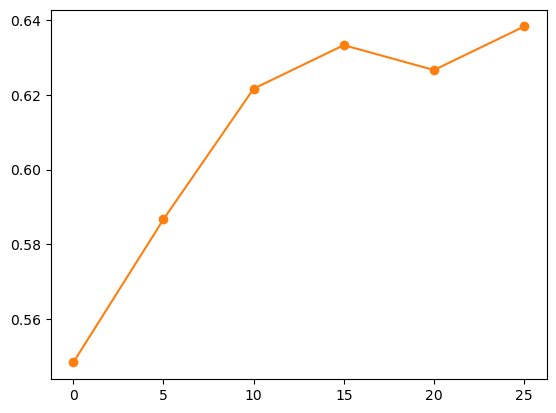

In [16]:
plt.plot(db_list, ridge_means, marker = 'o', label='Ridge', color=c_ridge)

# Load reconstruction Scores for decoding significances

In [17]:
cnn_model_id_list

[153, 306, 305, 303, 301, 300]

In [18]:
db_list

[25, 20, 15, 10, 5, 0]

### 1. CNN data

In [19]:
cnn_ref_attended, cnn_ref_distractor = get_attended_distractor_data(cnn_model_id_list[0])
cnn_20dB_attended, cnn_20dB_distractor = get_attended_distractor_data(cnn_model_id_list[1])
cnn_15dB_attended, cnn_15dB_distractor = get_attended_distractor_data(cnn_model_id_list[2])
cnn_10dB_attended, cnn_10dB_distractor = get_attended_distractor_data(cnn_model_id_list[4])
cnn_5dB_attended, cnn_5dB_distractor = get_attended_distractor_data(cnn_model_id_list[4])
cnn_0dB_attended, cnn_0dB_distractor = get_attended_distractor_data(cnn_model_id_list[5])

### 2. Ridge data

In [20]:
ridge_ref_attended, ridge_ref_distractor = get_attended_distractor_data(ridge_model_id_list[0], CNN=False)
ridge_20dB_attended, ridge_20dB_distractor = get_attended_distractor_data(ridge_model_id_list[1], CNN=False)
ridge_15dB_attended, ridge_15dB_distractor = get_attended_distractor_data(ridge_model_id_list[2], CNN=False)
ridge_10dB_attended, ridge_10dB_distractor = get_attended_distractor_data(ridge_model_id_list[3], CNN=False)
ridge_5dB_attended, ridge_5dB_distractor = get_attended_distractor_data(ridge_model_id_list[4], CNN=False)
ridge_0dB_attended, ridge_0dB_distractor = get_attended_distractor_data(ridge_model_id_list[5], CNN=False)

### Assess significance of decoding in different scenarios

In [21]:
cnn_ref_sig = sig_decoding(cnn_ref_attended, cnn_ref_distractor)
cnn_20_dB_sig = sig_decoding(cnn_20dB_attended, cnn_20dB_distractor)
cnn_15_dB_sig = sig_decoding(cnn_15dB_attended, cnn_15dB_distractor)
cnn_10_dB_sig = sig_decoding(cnn_10dB_attended, cnn_10dB_distractor)
cnn_5_dB_sig = sig_decoding(cnn_5dB_attended, cnn_5dB_distractor)
cnn_0_dB_sig = sig_decoding(cnn_0dB_attended, cnn_0dB_distractor)

ridge_ref_sig = sig_decoding(ridge_ref_attended, ridge_ref_distractor)
ridge_20dB_sig = sig_decoding(ridge_20dB_attended, ridge_20dB_distractor)
ridge_15dB_sig = sig_decoding(ridge_15dB_attended, ridge_15dB_distractor)
ridge_10dB_sig = sig_decoding(ridge_10dB_attended, ridge_10dB_distractor)
ridge_5dB_sig = sig_decoding(ridge_5dB_attended, ridge_5dB_distractor)
ridge_0dB_sig = sig_decoding(ridge_0dB_attended, ridge_0dB_distractor)

population_significances = np.array([ridge_ref_sig, cnn_ref_sig, ridge_20dB_sig, cnn_20_dB_sig, ridge_15dB_sig, cnn_15_dB_sig, ridge_10dB_sig, cnn_10_dB_sig, ridge_5dB_sig, cnn_5_dB_sig, ridge_0dB_sig, cnn_0_dB_sig])

In [22]:
cnn_ref_sig = sig_decoding(cnn_ref_attended, cnn_ref_distractor, long_res=True)
print(cnn_ref_sig)

BinomTestResult(k=218, n=300, alternative='two-sided', statistic=0.7266666666666667, pvalue=2.1194841014780042e-15)


In [23]:
ridge_ref_sig = sig_decoding(ridge_ref_attended, ridge_ref_distractor, long_res=True)
print(ridge_ref_sig)

BinomTestResult(k=191, n=300, alternative='two-sided', statistic=0.6366666666666667, pvalue=2.54626341997208e-06)


### Asses signficance of improvement through artifact rejection

In [24]:
cnn_10dB_art_sig = ttest_rel(cnn_ref, cnn_10dB)
print(f'10db: {cnn_10dB_art_sig}')
cnn_25dB_art_sig = ttest_rel(cnn_ref, cnn_15dB)
print(f'25db: {cnn_25dB_art_sig}')

10db: TtestResult(statistic=-1.0631924080239625, pvalue=0.29827590463029163, df=24)
25db: TtestResult(statistic=-2.369828633334301, pvalue=0.02617899168033855, df=24)


### Plot tendency for different SNR thresholds in artifact rejectin

### Plot population performance

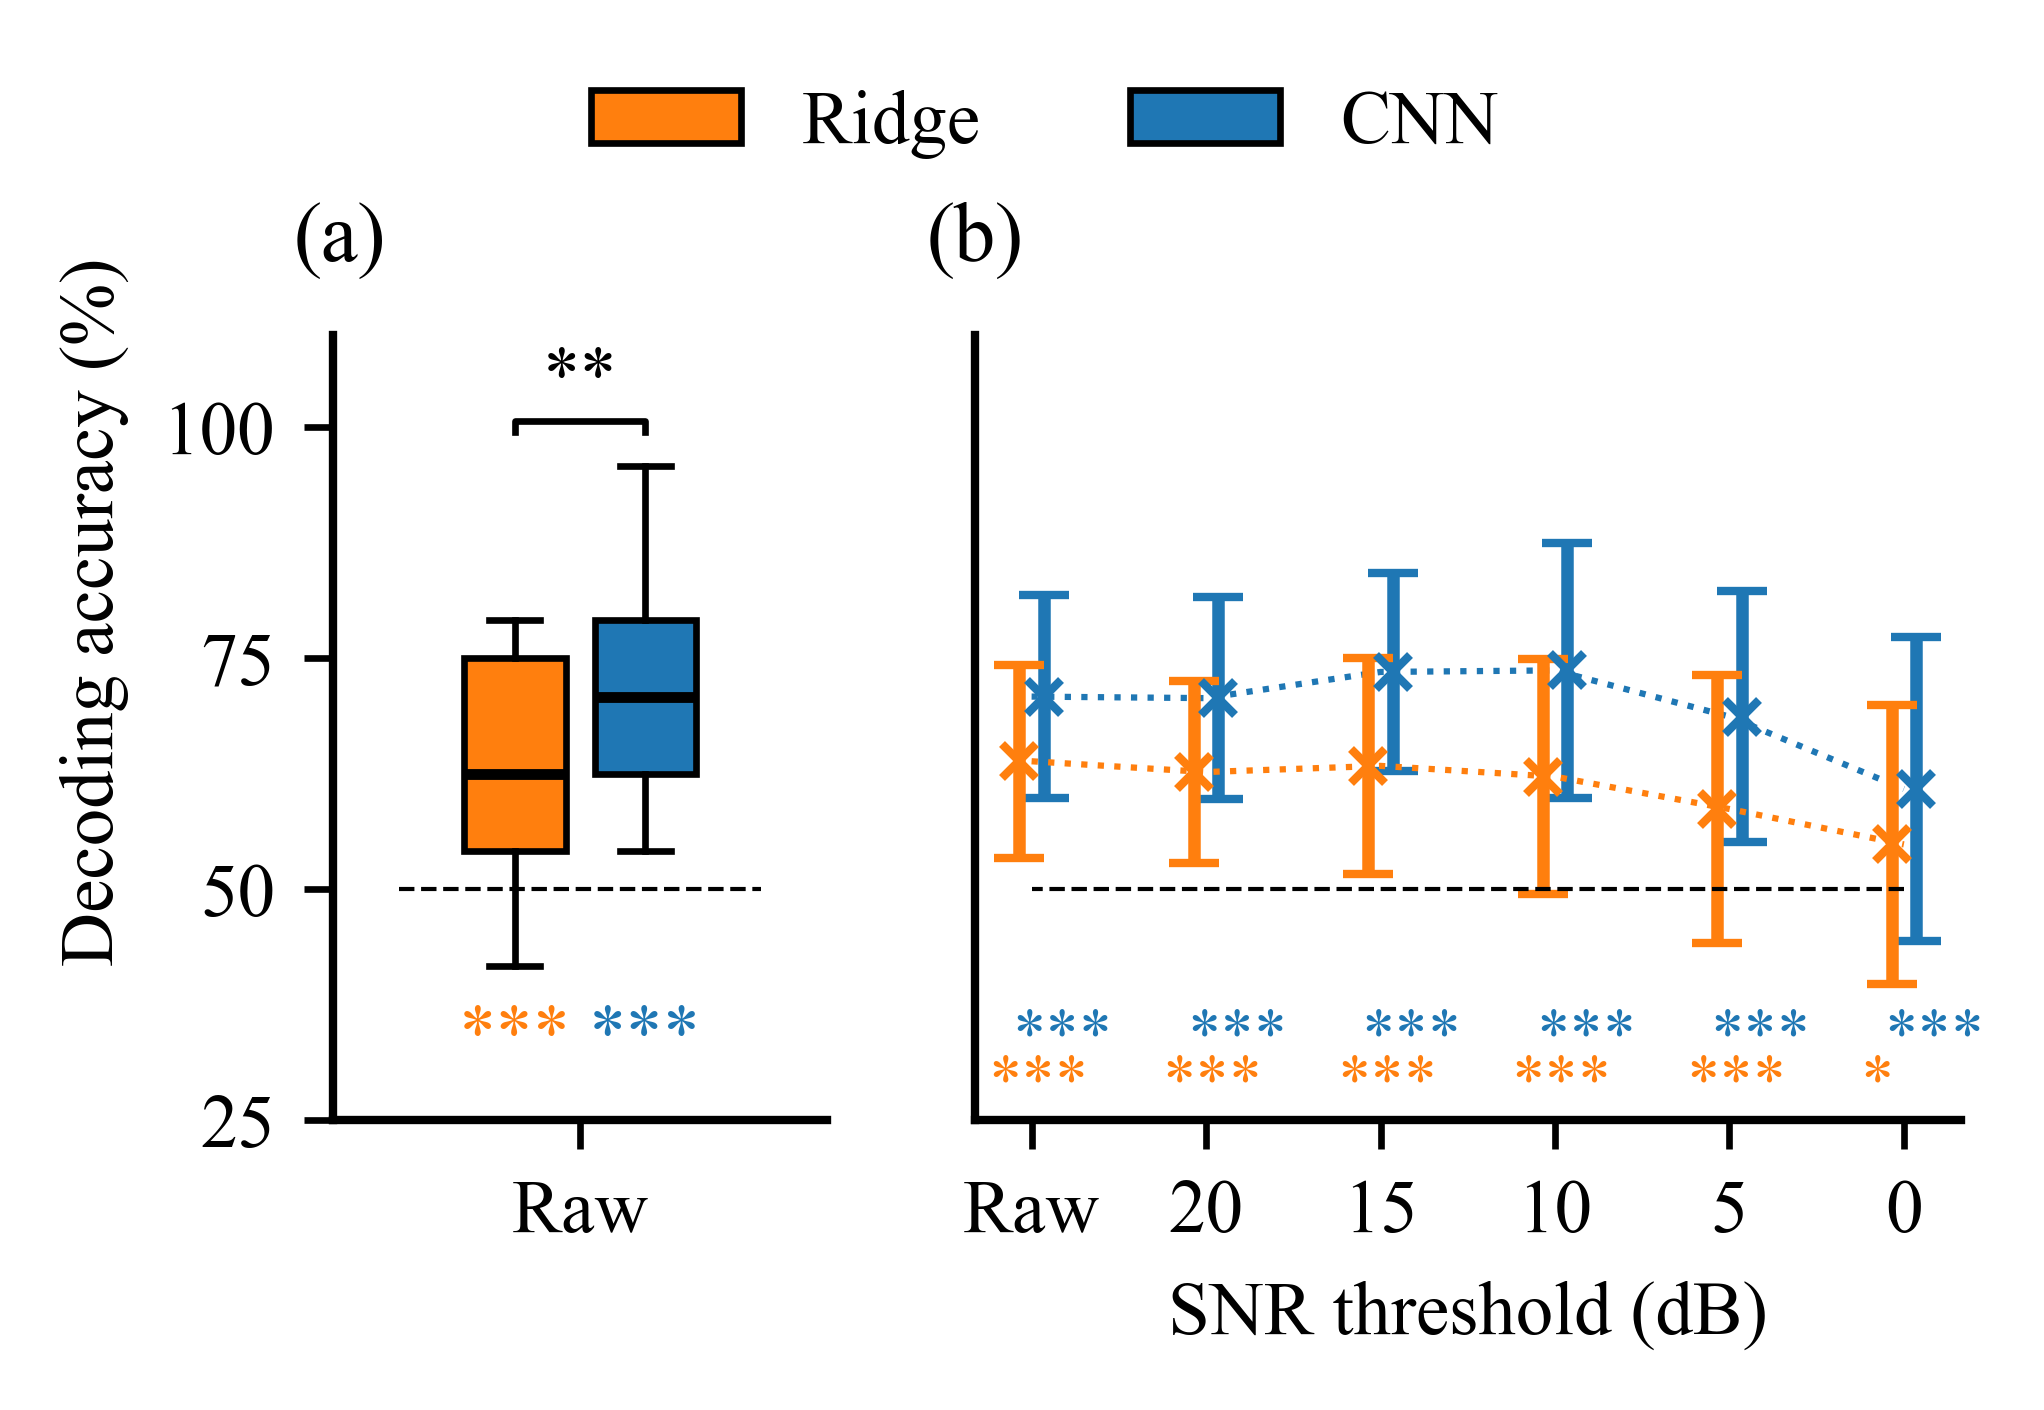

In [25]:
box_plot_widts = 0.28
box_plot_line_width = 0.8

marker_size_SNR = 4
cap_size = 3
linewidth = 0.75
elinewidth = 1.5
linestyle = 'dotted'


significant_box = population_significances < 0.05
box_plot_colors = [c_ridge, c_cnn, c_ridge, c_cnn, c_ridge, c_cnn, c_ridge, c_cnn]
flierprops = dict(marker='x', markerfacecolor='k', markersize=3, markeredgewidth=0.6)
boxprops = dict(linestyle='-', linewidth=box_plot_line_width, color='darkgoldenrod')

box_plot_flier_marker = 'x'
positions = np.array([[i-(box_plot_widts/2 + 0.04), i+(box_plot_widts/2 + 0.04)] for i in range(1,2)]).flatten()

scatter_delta = 0.06
marker = 'o'
marker_size = 10
tick_fontsize = 9
label_fontsize = 9
labels = ['Raw']
legend_fontsize = 9
plt.rcParams["font.family"] = "Times New Roman"

box_plot_data = np.vstack((ridge_ref.flatten(), cnn_ref.flatten())).T
significances = [ttest_rel(ridge_ref.flatten(),cnn_ref.flatten())]

p_vals = [s[1] for s in significances]

fig, (ax, ax1) = plt.subplots(1,2, figsize=(3.5,2.2), gridspec_kw={'width_ratios':[1,2]}, dpi=600)
box_plot = ax.boxplot(box_plot_data, showmeans=False, positions=positions, widths=box_plot_widts, patch_artist=True, showfliers=True, flierprops=flierprops, medianprops={"linewidth": box_plot_line_width + 0.5,
                        "solid_capstyle": "butt"})
box_plot = adjust_boxplot(box_plot, box_plot_line_width, significant_boxes=significant_box, flier_marker=box_plot_flier_marker, colors=box_plot_colors)

bottom, top = ax.get_ylim()
y_range = top - bottom
#significance bars
for i, p in zip(range(0, len(p_vals)), p_vals):
    x_0 = positions[i*2]
    x_1 = positions[i*2+1]
    level = 0.5
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    ax.plot([x_0, x_0, x_1, x_1], [bar_tips, bar_height, bar_height, bar_tips], lw=box_plot_line_width, c='k')
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'n.s.'
    text_height = bar_height + (y_range * 0.01)
    ax.text((x_0 + x_1)/2, text_height, sig_symbol, ha='center', va='bottom', color='k', fontsize=tick_fontsize)


for p, pos, c in zip(population_significances, positions, [c_ridge, c_cnn]):
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'n.s.'
    ax.text(pos, 0.3, sig_symbol, ha='center', va='bottom', color=c, fontsize=tick_fontsize)

ax.hlines(0.5, 0.5, 1.5, colors='k', linestyles='dashed', linewidth=0.5)
ax.set_xticks([i for i in range(1,2)])

ax.set_ylabel('Decoding accuracy (%)', fontsize = label_fontsize)
plt.legend([box_plot["boxes"][0], box_plot["boxes"][1]], ['Ridge', 'CNN'], bbox_to_anchor = (0.6,1.08), fontsize=legend_fontsize, ncols = 2, frameon=False)
ax.set_xticklabels(labels, rotation=0, fontsize = tick_fontsize)
ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.text(0.21, 1.18, '(a)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0, symbol=None))
for axis in [ax, ax1]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_bounds(0.25, 1.1)
    axis.spines['left'].set_linewidth(1.0)
    axis.spines['bottom'].set_linewidth(1.0)
    axis.tick_params(axis='y', labelsize=tick_fontsize)
    axis.set_ylim([0.25, 1.35])


ax1.plot(db_list, cnn_means, label='CNN mean', color=c_cnn, linewidth = linewidth, linestyle=linestyle)
for db, cnn_mean, ridge_mean, cnn_datapoint, ridge_datapoint, sig_cnn, sig_ridge in zip(db_list, cnn_means, ridge_means, cnn_data, ridge_data, population_significances[1::2], population_significances[::2]):
    if sig_cnn<0.001:
        text = '***'
        alpha = 1
    elif sig_cnn<0.01:
        text = '**'
        alpha = 1
    elif sig_cnn<0.05:
        text = '*'
        alpha = 1
    else:
        text = 'n.s.'
        alpha = 0.7
    ax1.errorbar(np.array(db) - 0.35, cnn_mean, yerr=[np.std(cnn_datapoint)], fmt='x', color=c_cnn, capsize=cap_size, markersize=marker_size_SNR, elinewidth=elinewidth, alpha = alpha)
    ax1.text(db - 0.35 +0.9, 0.32, text, fontsize=8, color=c_cnn)

    if sig_ridge<0.001:
        text = '***'
        alpha = 1
    elif sig_ridge<0.01:
        text = '**'
        alpha = 1
    elif sig_ridge<0.05:
        text = '*'
        alpha = 1
    else:
        text = 'n.s.'
        alpha = 0.7
    ax1.errorbar(np.array(db) + 0.35, ridge_mean, yerr=[np.std(ridge_datapoint)], fmt='x', color=c_ridge, capsize=cap_size, markersize=marker_size_SNR, elinewidth=elinewidth, alpha = alpha)
    ax1.text(db + 0.35 + 0.9, 0.27, text, fontsize=8, color=c_ridge)
ax1.plot(db_list, ridge_means, label='Ridge mean', color=c_ridge, linewidth = linewidth, linestyle=linestyle)

ax1.text(28, 1.18, '(b)')
#ax.plot(db_list, ridge_medians, label = 'Ridge median', color = c_ridge, marker = 's', alpha=0.5)
ax1.invert_xaxis()
x_labels = db_list.copy()
x_labels[0] = 'Raw'
ax1.set_xticks(db_list)
ax1.set_xticklabels(x_labels, fontsize=tick_fontsize)
ax1.set_xlabel('SNR threshold (dB)', fontsize = label_fontsize)
ax1.hlines(0.5, 0, 25, colors='k', linestyles='dashed', linewidth=0.5)


ax1.set_yticks([])


fig_path = os.path.join(base_dir, 'reports', 'figures', 'complete_dataset', 'ridge_vs_cnn_60s_SNR_thresholds')
extensions = ['.png', '.svg', '.pdf']
for ext in extensions:
    fig.savefig(fig_path + ext, bbox_inches='tight', dpi=600)

# Additional Statistics

In [26]:
#Normality
print(f'Normality CNN: {stats.shapiro(cnn_ref)}')
print(f'Normality Ridge: {stats.shapiro(ridge_ref)}')

Normality CNN: ShapiroResult(statistic=0.9606298804283142, pvalue=0.42716285586357117)
Normality Ridge: ShapiroResult(statistic=0.9304031133651733, pvalue=0.08879166841506958)


In [28]:
#Homoscedasticity
print(f'Homoscedasticity: {stats.levene(cnn_ref, ridge_ref)}')

Homoscedasticity: LeveneResult(statistic=0.0, pvalue=1.0)


In [34]:
#Effect size
eff_size = pg.compute_effsize(cnn_ref, ridge_ref, paired=True)
print(f'Effect size: {eff_size}')

Effect size: 0.6393334689943844


In [35]:
#Power analysis
from statsmodels.stats.power import TTestPower
power_analysis = TTestPower()
power = power_analysis.solve_power(effect_size=eff_size, nobs=25, alpha=0.05)
print(f'Power: {power}')

Power: 0.8657375626080096


In [36]:
significances

[TtestResult(statistic=-2.8300319062226786, pvalue=0.009258997445065293, df=24)]

In [28]:
ridge_means

[0.6383333333333333,
 0.6266666666666666,
 0.6333333333333333,
 0.6216666666666667,
 0.5866666666666667,
 0.5483333333333333]

In [29]:
[np.std(x) for x in ridge_data]

[0.10456258094238748,
 0.09893881386437219,
 0.11726039399558574,
 0.12743189902410185,
 0.14477952586989334,
 0.15123565129367553]

In [30]:
cnn_means

[0.7083333333333333,
 0.7066666666666667,
 0.735,
 0.7366666666666667,
 0.6866666666666668,
 0.6083333333333334]

In [33]:
#load models/cnn/checkpoints/150/125/test_ind_8/model_kwargs.pkl
kwargs = load_from_pickle('/Users/constantin/PhD_Code/model_dev_aad_semeco/models/cnn/checkpoints/150/125/test_ind_8/model_kwargs.pkl')

In [31]:
alt = 'less'
significances = [ttest_rel(cnn_ref, cnn_30dB, alternative=alt), ttest_rel(cnn_ref, cnn_25dB, alternative=alt), ttest_rel(cnn_ref, cnn_20dB, alternative=alt), ttest_rel(cnn_ref, cnn_15dB, alternative=alt), ttest_rel(cnn_ref, cnn_10dB, alternative=alt)]

NameError: name 'cnn_30dB' is not defined

In [ ]:
significances

[TtestResult(statistic=-1.687391667750582, pvalue=0.05224204111529518, df=24),
 TtestResult(statistic=-2.34216017507648, pvalue=0.0139003854514754, df=24),
 TtestResult(statistic=0.06843859108291517, pvalue=0.5269982437024356, df=24),
 TtestResult(statistic=1.190409830385613, pvalue=0.8772363353725183, df=24),
 TtestResult(statistic=6.708264154905522, pvalue=0.9999996931963876, df=24)]

In [ ]:
p_vals = [s[1] for s in significances[:]]

In [ ]:
multipletests(p_vals,alpha=0.05, method='fdr_bh')

(array([False, False, False, False, False]),
 array([0.1306051 , 0.06950193, 0.87833041, 0.99999969, 0.99999969]),
 0.010206218313011495,
 0.01)

In [2]:
0.63 * 275

173.25

In [6]:
import scipy
scipy.stats.binomtest(int(0.63*275), 275, p=0.5, alternative='two-sided')

BinomTestResult(k=173, n=275, alternative='two-sided', statistic=0.6290909090909091, pvalue=2.2036265459613615e-05)

### Compare to number of rejected components

In [ ]:
ica_corr_dir = os.path.join(base_dir, 'data', 'ica', 'corr_criterium')
trials = list(range(1, 21))
snr_thres_list = [30, 25, 20, 15, 10]
n_rejected_list = []
for subj in subjects:
    n_rejected_subj = []
    peak_json_dir = os.path.join(ica_corr_dir, str(subj), f'subj{str(subj)}_peak_channels.json')
    with open(peak_json_dir, 'r') as f:
        peak_channels = json.load(f)
        for trial in trials:
            n_rejected_trial = []
            for snr_thres in snr_thres_list:
                snrs = peak_channels[f'trial_{str(trial)}']['snr']
                snrs = np.array(snrs)
                peaking_channels = np.where(snrs > snr_thres)[0]
                peaking_channels = list(peaking_channels)
                n_rejected = len(peaking_channels)
                n_rejected_trial.append(n_rejected)
            n_rejected_subj.append(n_rejected_trial)
    n_rejected_list.append(n_rejected_subj)

n_rejected_list = np.array(n_rejected_list)

In [ ]:
cnn_ref

array([0.54166667, 0.75      , 0.79166667, 0.625     , 0.70833333,
       0.75      , 0.79166667, 0.70833333, 0.58333333, 0.75      ,
       0.66666667, 0.66666667, 0.83333333, 0.75      , 0.66666667,
       0.66666667, 0.83333333, 0.66666667, 0.91666667, 0.58333333,
       0.95833333, 0.54166667, 0.625     , 0.79166667, 0.54166667])

In [ ]:
stats.linregress(rejected_25dB_per_subjects, cnn_ref)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


LinregressResult(slope=-0.0008417127724259924, intercept=0.7108248031397142, rvalue=-0.02789011832235667, pvalue=0.89471806201855, stderr=0.006290434825078403, intercept_stderr=0.029523658449291796)

Text(0, 0.5, 'Decoding accuracy CNN')

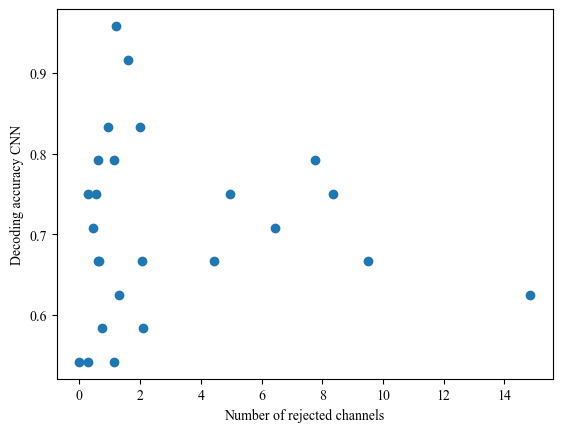

In [38]:
plt.scatter(rejected_25dB_per_subjects, cnn_ref)
plt.xlabel('Number of rejected channels')
plt.ylabel('Decoding accuracy CNN')